In [308]:
# The following libraries will let you use opencv
import cv2 #opencv itself
import numpy as np # matrix manipulations
import pandas as pd # dataframes
import os
#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks

In [309]:
def face_detect(photo, scaleFactor=1.2, minNeighbors=5, facecolor =(255,0,0), eyecolor =(0,255,0), smilecolor =(0,0,255), thickness=2, smilescale = 2, eyescale = 4):
    person_grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    #person_grey = cv2.GaussianBlur(person_grey, (5, 5),0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
    eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    max_width = 0
    max_height = 0
    for (x, y, w, h) in faces:
        cv2.rectangle(photo, (x, y), (x+w, y+h), facecolor, thickness)
        max_width = w if w > max_width else max_width
        max_height = h if h > max_height else max_height

    smile_max_width = int(max_width / smilescale)
    smile_max_height = int(max_height / smilescale)
    smile = smile_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors, maxSize=(smile_max_width,smile_max_height))
    for (x, y, w, h) in smile:
        cv2.rectangle(photo, (x, y), (x+w, y+h), smilecolor, thickness)

    eyes_max_width = int(max_width / eyescale)
    eyes_max_height = int(max_height / eyescale)
    eyes = eyes_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors, maxSize=(eyes_max_width,eyes_max_height))
    for (x, y, w, h) in eyes:
        cv2.rectangle(photo, (x, y), (x+w, y+h), eyecolor, thickness)

    cv2.putText(photo,'Face', (0,(int(0.05*photo.shape[1]))), cv2.FONT_HERSHEY_PLAIN, 1, facecolor, 1)
    cv2.putText(photo,'Smile', (0,(int(0.1*photo.shape[1]))), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
    cv2.putText(photo,'Eyes', (0,(int(0.15*photo.shape[1]))), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)

    plt.imshow(photo)

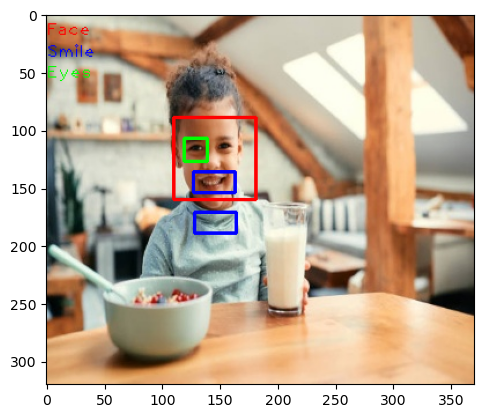

In [310]:
face_detect(cv2.imread('data/control/3.jpg'))


In [311]:
def proportions(photo, scaleFactor=1.1, minNeighbors=5):
    person_grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(person_grey, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    n = 0
    data = pd.DataFrame(columns=['Face', 'Face_x', 'Face_y', 'Face_w', 'Face_h', 'Smile_x', 'Smile_y', 'Smile_w', 'Smile_h', 'Eye1_x', 'Eye1_y', 'Eye1_w', 'Eye1_h', 'Eye2_x', 'Eye2_y', 'Eye2_w', 'Eye2_h'])
    for (x, y, w, h) in faces:
        cv2.rectangle(photo, (x, y), (x+w, y+h), [255,0,0], 1)
        n += 1
        data.loc[n, 'Face'] = n
        smile = smile_cascade.detectMultiScale(person_grey[y:(y+h), x:(x+w)], scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        data.loc[n, ['Face_x', 'Face_y', 'Face_w', 'Face_h']] = [x, y, w, h]
        for (xs, ys, ws, hs) in smile:
            data.loc[n, ['Smile_x', 'Smile_y', 'Smile_w', 'Smile_h']] = [x+xs, y+ys, ws, hs]
        eye = eye_cascade.detectMultiScale(person_grey[y:(y+h), x:(x+w)], scaleFactor=scaleFactor, minNeighbors=minNeighbors)
        for (xe, ye, we, he) in eye:
            if pd.isna(data.loc[n, 'Eye1_x']):
                data.loc[n, ['Eye1_x', 'Eye1_y', 'Eye1_w', 'Eye1_h']] = [x+xe, y+ye, we, he]
            elif pd.isna(data.loc[n, 'Eye2_x']):
                data.loc[n, ['Eye2_x', 'Eye2_y', 'Eye2_w', 'Eye2_h']] = [x+xe, y+ye, we, he]
    return(data)

In [312]:
facial_data = proportions(cv2.imread('Images/Day 2_Programming Lab_Person.jpg'), 1.1, 5)

facial_data

,Face,Face_x,Face_y,Face_w,Face_h,Smile_x,Smile_y,Smile_w,Smile_h,Eye1_x,Eye1_y,Eye1_w,Eye1_h,Eye2_x,Eye2_y,Eye2_w,Eye2_h
1,1,181,47,137,137,209,134,71,36,206,78,38,38,254,86,37,37


In [313]:
def proportions_processing(data):
    required_columns = ['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop', 'forehead_prop', 'nose_prop', 'chin_prop']

    if type(data) == pd.DataFrame:
        missing_columns = [col for col in required_columns if col not in data.columns]
        for col in missing_columns:
            data[col] = np.nan

        data[['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop']] = data[['Smile_w', 'Eye1_w', 'Eye2_w']].div(data['Face_w'], axis=0)
        data[['Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop']] = data[['Smile_h', 'Eye1_h', 'Eye2_h']].div(data['Face_h'], axis=0)
        data['forehead_prop'] = ((((data['Face_y']+data['Face_h'])-np.mean([(data['Eye1_y']+data['Eye1_h']),(data['Eye2_y']+data['Eye2_h'])]))/data['Face_h']).iloc[0])
        data['nose_prop'] = ((((np.mean([(data['Eye1_y']+0.5*data['Eye1_h']),(data['Eye2_y']+0.5*data['Eye2_h'])]))-(data['Smile_y']+data['Smile_h']))/data['Face_h']).iloc[0])
        data['chin_prop'] = (((data['Smile_y']-data['Face_y'])/data['Face_h']).iloc[0])
    else:
        missing_columns = [col for col in required_columns if col not in data.index]
        for col in missing_columns:
            data[col] = np.nan

        data[['Smile_w_prop', 'Eye1_w_prop', 'Eye2_w_prop']] = data[['Smile_w', 'Eye1_w', 'Eye2_w']].div(data['Face_w'], axis=0)
        data[['Smile_h_prop', 'Eye1_h_prop', 'Eye2_h_prop']] = data[['Smile_h', 'Eye1_h', 'Eye2_h']].div(data['Face_h'], axis=0)
        data['forehead_prop'] = ((((data['Face_y']+data['Face_h'])-np.mean([(data['Eye1_y']+data['Eye1_h']),(data['Eye2_y']+data['Eye2_h'])]))/data['Face_h']))
        data['nose_prop'] = ((((np.mean([(data['Eye1_y']+0.5*data['Eye1_h']),(data['Eye2_y']+0.5*data['Eye2_h'])]))-(data['Smile_y']+data['Smile_h']))/data['Face_h']))
        data['chin_prop'] = (((data['Smile_y']-data['Face_y'])/data['Face_h']))
    return(data)

In [314]:
data = facial_data.copy()

proportions_processing(data)

,Face,Face_x,Face_y,Face_w,Face_h,Smile_x,Smile_y,Smile_w,Smile_h,Eye1_x,...,Eye2_h,Smile_w_prop,Eye1_w_prop,Eye2_w_prop,Smile_h_prop,Eye1_h_prop,Eye2_h_prop,forehead_prop,nose_prop,chin_prop
1,1,181,47,137,137,209,134,71,36,206,...,37,0.518248,0.277372,0.270073,0.262774,0.277372,0.270073,0.474453,-0.505474,0.635036


In [409]:
def proportions_overlay(photo, data, facecolor =(255,0,0), eyecolor =(0,255,0), smilecolor =(0,0,255), thickness=2):
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)

    try:
        data = dict(data.iloc[0])
    except:
        print("No face detected")
        return

    if any(pd.isna([data['Face_x'], data['Face_y'], data['Face_w'], data['Face_h']])):
        print("No face detected")
    else:
        cv2.rectangle(photo, (data['Face_x'], data['Face_y']), (data['Face_x']+data['Face_w'], data['Face_y']+data['Face_h']), facecolor, thickness)
        cv2.putText(photo,'Face', (0,15), cv2.FONT_HERSHEY_PLAIN, 1, facecolor, 1)
        
    if any(pd.isna([data['Smile_x'], data['Smile_y'], data['Smile_w'], data['Smile_h']])):
        print("No smile detected")
    else:
        pt1 = (int(data['Smile_x']), int(data['Smile_y']))
        pt2 = (int(data['Smile_x'] + data['Smile_w']), int(data['Smile_y'] + data['Smile_h']))
        cv2.rectangle(photo, pt1, pt2, smilecolor, thickness)
        #cv2.rectangle(photo, (data['Smile_x'], data['Smile_y']), ((data['Smile_x']+data['Smile_w']), (data['Smile_y']+data['Smile_h'])), smilecolor, thickness)
        cv2.putText(photo,'Smile', (0,30), cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
        text1 = str(data['Smile_w_prop'])
        pt1 = (data['Smile_x']-35, int(data['Smile_y']+(data['Smile_y']+data['Smile_h'])/2))
        cv2.putText(photo,text1, pt1, cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
        text1 = str(data['Smile_h_prop'])
        pt1 = (int(data['Smile_x']+(data['Smile_w'])/2),(data['Smile_y']-10))
        cv2.putText(photo,text1, pt1, cv2.FONT_HERSHEY_PLAIN, 1, smilecolor, 1)
        
    if any(pd.isna([data['Eye1_x'], data['Eye1_y'], data['Eye1_w'], data['Eye1_h']])):
        print("No eye detected")
    else:
        
        pt1 = (int(data['Eye1_x']), int(data['Eye1_y']))
        pt2 = (int(data['Eye1_x'] + data['Eye1_w']), int(data['Eye1_y'] + data['Eye1_h']))
        cv2.rectangle(photo, pt1, pt2, eyecolor, thickness)

        #cv2.rectangle(photo, (data['Eye1_x'], data['Eye1_y']), (data['Eye1_x']+data['Eye1_w'], data['Eye1_y']+data['Eye1_h']), eyecolor, thickness)
        cv2.putText(photo,'Eyes', (0,50), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        cv2.putText(photo,str(data['Eye1_w_prop']), ((data['Eye1_x']-35),int(data['Eye1_y']+(data['Eye1_y']+data['Eye1_h'])/2)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        cv2.putText(photo,str(data['Eye1_h_prop']), (int(data['Eye1_x']+(data['Eye1_w'])/2),(data['Eye1_y']-10)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        
    if any(pd.isna([data['Eye2_x'], data['Eye2_y'], data['Eye2_w'], data['Eye2_h']])):
        print("Second eye not detected")
    else:
        pt1 = (int(data['Eye2_x']), int(data['Eye2_y']))
        pt2 = (int(data['Eye2_x'] + data['Eye2_w']), int(data['Eye2_y'] + data['Eye2_h']))
        cv2.rectangle(photo, pt1, pt2, eyecolor, thickness)
        #cv2.rectangle(photo, (data['Eye2_x'], data['Eye2_y']), (data['Eye2_x']+data['Eye2_w'], data['Eye2_y']+data['Eye2_h']), eyecolor, thickness)
        cv2.putText(photo,str(data['Eye2_w_prop']), ((data['Eye2_x']-35),int(data['Eye2_y']+(data['Eye2_y']+data['Eye2_h'])/2)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)
        cv2.putText(photo,str(data['Eye2_h_prop']), (int(data['Eye2_x']+(data['Eye2_w'])/2),(data['Eye2_y']-10)), cv2.FONT_HERSHEY_PLAIN, 1, eyecolor, 1)

    plt.imshow(photo)

In [397]:
control_data = pd.DataFrame()
control = 0
for files in os.listdir('.\data\control'):
    if files.endswith('.jpg') or files.endswith('.png') or files.endswith('.jpeg'):
        control += 1
        print(f"Processing {files}")
        img = cv2.imread(os.path.join('.\data\control', files))
        data = proportions(img, 1.1, 5)
        data['Image'] = files
        control_data = pd.concat([control_data, data], ignore_index=True)

Processing 0.jpg
Processing 002.jpg
Processing 004.jpg
Processing 0052.jpg
Processing 0058.jpg
Processing 0094.jpg
Processing 0098.jpg
Processing 0179.jpg
Processing 0184.jpg
Processing 0188.jpg
Processing 0212.jpg
Processing 0223.jpg
Processing 0280.jpg
Processing 0287.jpg
Processing 0292.jpg
Processing 0305.jpg
Processing 0354.jpg
Processing 0356.jpg
Processing 0359.jpg
Processing 0376.jpg
Processing 0377.jpg
Processing 0381.jpg
Processing 0398.jpg
Processing 0405.jpg
Processing 0438.jpg
Processing 0583.jpg
Processing 0590.jpg
Processing 0593.jpg
Processing 0596.jpg
Processing 0618.jpg
Processing 0647.jpg
Processing 0666.jpg
Processing 0721.jpg
Processing 0722.jpg
Processing 0734.jpg
Processing 0736.jpg
Processing 0739.jpg
Processing 0748.jpg
Processing 0805.jpg
Processing 0810.jpg
Processing 0815.jpg
Processing 0820.jpg
Processing 0891.jpg
Processing 0904.jpg
Processing 0921.jpg
Processing 1.jpg
Processing 10.jpg
Processing 100.jpg
Processing 101.jpg
Processing 102.jpg
Processing 10

In [398]:
noncontrol_data = pd.DataFrame()
noncontrol = 0
for files in os.listdir('.\data\downSyndrome'):
    if files.endswith('.jpg') or files.endswith('.png') or files.endswith('.jpeg'):
        noncontrol += 1
        print(f"Processing {files}")
        img = cv2.imread(os.path.join('.\data\downSyndrome', files))
        data = proportions(img, 1.1, 5)
        data['Image'] = files
        noncontrol_data = pd.concat([noncontrol_data, data], ignore_index=True)

Processing down_1.jpg
Processing down_10.jpg
Processing down_100.jpg
Processing down_1000.jpg
Processing down_1001.jpg
Processing down_1002.jpg
Processing down_1003.jpg
Processing down_1004.jpg
Processing down_1005.jpg
Processing down_1006.jpg
Processing down_1007.jpg
Processing down_1008.jpg
Processing down_1009.jpg
Processing down_101.jpg
Processing down_1010.jpg
Processing down_1011.jpg
Processing down_1012.jpg
Processing down_1013.jpg
Processing down_1014.jpg
Processing down_1015.jpg
Processing down_1016.jpg
Processing down_1017.jpg
Processing down_1018.jpg
Processing down_1019.jpg
Processing down_102.jpg
Processing down_1020.jpg
Processing down_1021.jpg
Processing down_1022.jpg
Processing down_1023.jpg
Processing down_1024.jpg
Processing down_1025.jpg
Processing down_1026.jpg
Processing down_1027.jpg
Processing down_1028.jpg
Processing down_1029.jpg
Processing down_103.jpg
Processing down_1030.jpg
Processing down_1031.jpg
Processing down_1032.jpg
Processing down_1033.jpg
Processin

In [322]:
control_data['Classification'] = 'Control'
noncontrol_data['Classification'] = 'DownSyndrome'

all_data = pd.concat([control_data, noncontrol_data], ignore_index=True)

writer = pd.ExcelWriter('all_data_raw.xlsx')
all_data.to_excel(writer, sheet_name='Sheet1', index=False)

all_data.isnull().sum()

Face                0
Face_x              0
Face_y              0
Face_w              0
Face_h              0
Smile_x           233
Smile_y           233
Smile_w           233
Smile_h           233
Eye1_x            200
Eye1_y            200
Eye1_w            200
Eye1_h            200
Eye2_x            366
Eye2_y            366
Eye2_w            366
Eye2_h            366
Image               0
Classification      0
dtype: int64

In [323]:
data_processed = all_data.apply(proportions_processing, axis=1)
data_processed = data_processed.dropna()

data_processed

,Face,Face_x,Face_y,Face_w,Face_h,Smile_x,Smile_y,Smile_w,Smile_h,Eye1_x,...,Classification,Smile_w_prop,Eye1_w_prop,Eye2_w_prop,Smile_h_prop,Eye1_h_prop,Eye2_h_prop,forehead_prop,nose_prop,chin_prop
1,1,20,112,218,218,26.0,182.0,120.0,60.0,57.0,...,Control,0.550459,0.293578,0.243119,0.275229,0.293578,0.243119,0.479358,-0.209862,0.321101
2,1,16,44,239,239,82.0,95.0,132.0,66.0,150.0,...,Control,0.552301,0.092050,0.246862,0.276151,0.092050,0.246862,0.410042,0.015690,0.213389
3,1,31,21,364,364,256.0,111.0,94.0,47.0,163.0,...,Control,0.258242,0.162088,0.131868,0.129121,0.162088,0.131868,0.282967,0.267170,0.247253
4,1,26,127,250,250,80.0,283.0,142.0,71.0,162.0,...,Control,0.568000,0.252000,0.280000,0.284000,0.252000,0.280000,0.484000,-0.525000,0.624000
6,1,24,46,184,184,64.0,174.0,113.0,56.0,94.0,...,Control,0.614130,0.114130,0.331522,0.304348,0.114130,0.331522,0.320652,-0.432065,0.695652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,1,99,94,390,390,289.0,377.0,100.0,50.0,249.0,...,DownSyndrome,0.256410,0.058974,0.105128,0.128205,0.058974,0.105128,0.320513,-0.215385,0.725641
1425,1,35,66,107,107,73.0,146.0,45.0,23.0,92.0,...,DownSyndrome,0.420561,0.233645,0.214953,0.214953,0.233645,0.214953,0.490654,-0.565421,0.747664
1426,1,79,123,156,156,103.0,154.0,111.0,55.0,177.0,...,DownSyndrome,0.711538,0.179487,0.307692,0.352564,0.179487,0.307692,0.500000,-0.173077,0.198718
1428,1,45,60,124,124,75.0,138.0,67.0,34.0,114.0,...,DownSyndrome,0.540323,0.241935,0.258065,0.274194,0.241935,0.258065,0.483871,-0.512097,0.629032


In [399]:
print(control)
print(noncontrol)

572
1500


In [396]:
data_processed['Classification'].value_counts()

Classification
DownSyndrome    802
Control         173
Name: count, dtype: int64

In [407]:
def check_detection(file):
    photo = cv2.imread(file)
    data = data_processed[data_processed['Image'] == os.path.basename(file)]
    proportions_overlay(photo, data)
    plt.show()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type


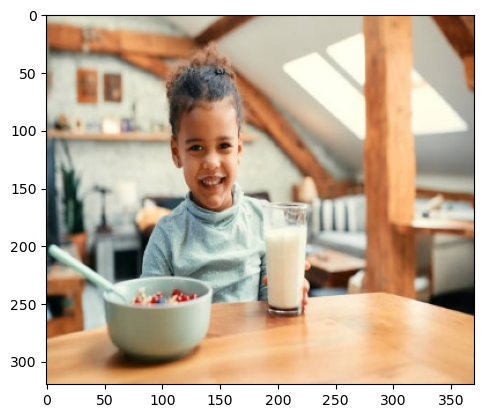

In [408]:
file = 'data/control/3.jpg'
plt.imshow(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
check_detection(file)

In [347]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import train_test_split


In [328]:
classification_features = data_processed[['Smile_w_prop', 'Smile_h_prop', 'Eye1_w_prop', 'Eye2_w_prop', 'forehead_prop', 'nose_prop', 'chin_prop']]

classification_target = data_processed['Classification']

In [377]:
train_features, test_features, train_target, test_target = train_test_split(classification_features, classification_target, test_size=0.2, random_state=1, stratify= classification_target)

In [378]:
print(train_features.shape)
print(test_features.shape)
print(train_target.shape)
print(test_target.shape)

(780, 7)
(195, 7)
(780,)
(195,)


In [389]:
for neighbours in range(1, 11):
    print(neighbours)
    knn = KNeighborsClassifier(n_neighbors=neighbours)

    knn.fit(train_features, train_target)

    print(knn.score(test_features, test_target))

1
0.7743589743589744
2
0.7076923076923077
3
0.8358974358974359
4
0.8153846153846154
5
0.841025641025641
6
0.8358974358974359
7
0.8256410256410256
8
0.8256410256410256
9
0.8307692307692308
10
0.8358974358974359


In [390]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train_features, train_target)

prediction = knn.predict(test_features)

In [391]:
accuracy = knn.score(test_features, test_target)

def precision(actual, predicted, positive='DownSyndrome'):
    TP = np.sum((actual == positive) & (predicted == positive))
    TN = np.sum((actual != positive) & (predicted != positive))
    FP = np.sum((actual != positive) & (predicted == positive))
    FN = np.sum((actual == positive) & (predicted != positive))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    output = f"Precision: {precision*100:.1f}% (TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN})"
    return(output)

print(precision(test_target, prediction, positive='DownSyndrome'))
print(precision(test_target, prediction, positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")

Precision: 86.0% (TP: 154, TN: 10, FP: 25, FN: 6)
Precision: 62.5% (TP: 10, TN: 154, FP: 6, FN: 25)
Overall accuracy: 84.1%


In [385]:
for depth in range(1, 11):
    print(depth)
    tree = DecisionTreeClassifier(max_depth=depth)

    tree.fit(train_features, train_target)

    print(tree.score(test_features, test_target))

1
0.8205128205128205
2
0.841025641025641
3
0.841025641025641
4
0.8256410256410256
5
0.7846153846153846
6
0.7897435897435897
7
0.7794871794871795
8
0.7589743589743589
9
0.7538461538461538
10
0.7076923076923077


In [402]:
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(classification_features, classification_target)

prediction = tree.predict(classification_features)

In [403]:
accuracy = tree.score(classification_features, classification_target)

print(precision(classification_target, prediction, positive='DownSyndrome'))
print(precision(classification_target, prediction, positive='Control'))
print(f"Overall accuracy: {accuracy*100:.1f}%")

Precision: 85.9% (TP: 783, TN: 45, FP: 128, FN: 19)
Precision: 70.3% (TP: 45, TN: 783, FP: 19, FN: 128)
Overall accuracy: 84.9%


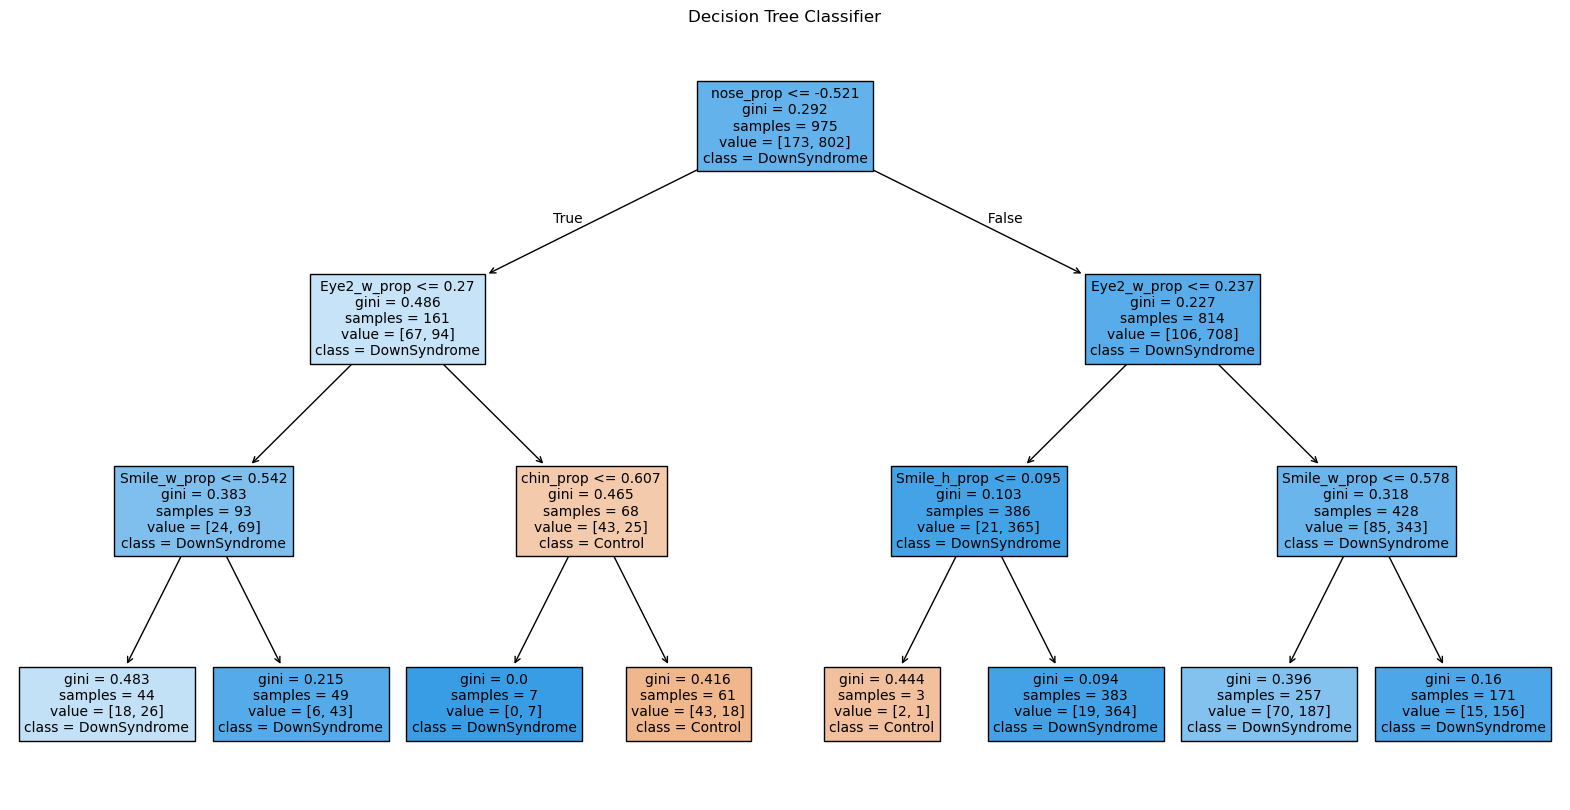

In [405]:
# Create a tree plot for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=classification_features.columns,
          # Use the class names from the classification target to colour the diagram
          class_names = classification_target.unique(),
          filled=True, fontsize=10)
plt.title(f'Decision Tree Classifier')
plt.show()

In [335]:
from joblib import dump, load
dump(tree, 'tree.joblib')
tree_load = load('tree.joblib')

In [336]:
file = 'data/control/87.jpg'
check_detection(file)

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type
